In [1]:
import psycopg2
import json
import math
import random
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

import matplotlib.pyplot as plt
%matplotlib inline

# Allow auto-reload of external modules 
%load_ext autoreload
%autoreload 2

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [47]:
def connect(broken):# Set connection to gis db
    if broken:
        conn.close()
    try:
        conn = psycopg2.connect("dbname=gis user=jennyzhou")
    except:
        print 'Fail to connect to Postgres Server'
    return conn
        
conn = connect(False)

In [50]:
cur = conn.cursor()
vid = 38
# Select vornoi polygon and transformer
cur.execute("SELECT ST_AsGeoJSON((ST_FlipCoordinates(ST_Transform(way, 4326)))), "
            "ST_AsGeoJSON((ST_FlipCoordinates(ST_Transform(tway, 4326)))) FROM vornoi WHERE vid = %d ;" % vid)
data = cur.fetchall()

# Select all the houses
cur.execute("SELECT ST_AsGeoJSON(ST_Collect(ST_FlipCoordinates(ST_Transform(way, 4326)))) "
            "FROM vornoi_map where vid = %d and istransformer = false ;" % vid)
houses = cur.fetchall()
cur.close()

vornoiJson = json.loads(data[0][0])
transJson = json.loads(data[0][1])
houseJson = json.loads(houses[0][0])

In [154]:
cur = conn.cursor()
cur.execute("SELECT oid FROM vornoi_map WHERE vid = %d;"%vid)
nodeNameLists = cur.fetchall()

# Select vornoi polygon and transformer
cur.execute("SELECT t1.oid, t2.oid, ST_Distance(t1.way, t2.way) "
            "FROM (SELECT oid, way FROM vornoi_map WHERE vid = %d) AS t1, "
            "(SELECT oid, way FROM vornoi_map WHERE vid = %d and istransformer = False) AS t2 "
            "WHERE t1.oid != t2.oid ;"% (vid,vid))
edges = cur.fetchall()
cur.close()

In [96]:
import numpy as np
nodeNameDict = {}
inx = 1
# Create Dict{osmId:intId}
for name in nodeNameLists:
    nodeNameDict[name[0]]= inx
    inx += 1
#print nodeNameDict, inx

# Create adjacent matrix for edge weight 
nodeNum = inx - 1
adjWeightMap = np.empty([inx,inx], dtype=float)
for e in edges:
    u = nodeNameDict[e[0]]
    v = nodeNameDict[e[1]]
    w = e[2]
    adjWeightMap[u][v] = w


## Calculate optimal tree and optimal weight with result from NetworkX

In [181]:
import networkx as nx
graph = []
for ele in edges:
    graph.append("%d %d %f" % ele)
G = nx.parse_edgelist(graph, nodetype = int, data=(('weight',float),))

MST = nx.minimum_spanning_tree(G)

nxAdjDict = nx.to_dict_of_dicts(MST, edge_data=None)
optTree = {} 
optTotal = 0
optTotalNx = 0
for key in nxAdjDict.keys():
    val = []
    for skey in nxAdjDict[key]:
        val.append(nodeNameDict[skey])
        optTotalNx += nxAdjDict[key][skey]['weight']
        optTotal += adjWeightMap[nodeNameDict[key]][nodeNameDict[skey]]
    optTree[nodeNameDict[key]] = val
optPrufer = treeToPrufer(optTree)
print optTotal,optTotalNx
print optPrufer

4325.74462257 4364.576742
[4, 26, 5, 6, 7, 8, 9, 11, 12, 16, 17, 18, 24, 22, 23, 27, 29, 25, 32, 1, 30, 41, 41, 40, 64, 65, 66, 67, 68, 81, 78, 77, 76, 82, 83, 85, 87, 79, 88, 86, 79, 76, 75, 74, 73, 72, 71, 70, 69, 62, 61, 60, 59, 58, 57, 56, 55, 53, 52, 51, 50, 49, 19, 18, 12, 10, 14, 13, 43, 44, 45, 46, 47, 48, 54, 30, 29, 28, 23, 24, 25, 32, 33, 34, 38, 39, 40, 91, 89]


[(1, 3, {'weight': 2.0}), (2, 3, {'weight': 1.0}), (3, 4, {'weight': 2.0})]


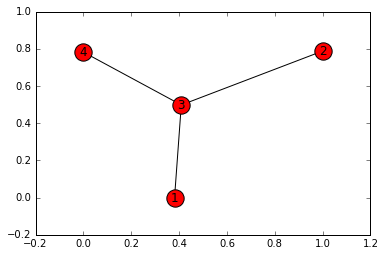

In [26]:
# Test with a small example 
import numpy as np
import networkx as nx

inx = 5
adjWeightMap = np.array([[0,0,0,0,0],
                         [0,0,3,2,5],
                         [0,3,0,1,3],
                         [0,2,1,0,2],
                         [0,5,3,2,0]],dtype=float)
graph = ["1 2 3", "1 3 2", "1 4 5", "2 3 1", "2 4 3","3 4 2"]
G = nx.parse_edgelist(graph, nodetype = int, data=(('weight',float),))
G = nx.minimum_spanning_tree(G)
print G.edges(data=True)
nx.draw_networkx(G,pos=nx.spring_layout(G),) 
plt.show()

In [27]:
from genetic import *
nodeNum = 4
tree = {1: [3], 2: [3], 3: [1,2,4], 4: [3]}
p = tree_to_prufer(tree)
tree, edges= prufer_to_tree(p, nodeNum)
print p, edges

[3, 3] [(1, 3), (2, 3), (3, 4)]


In [29]:
from genetic import *

pop_size = 3       # totoal population of a generation
gen_max = 20        # max amount of generation
cross_prob = 0.8     # probability of crossover
mutat_prob = 0.052        # probability of mutation
#node_num = nodeNum -83
node_num = 4
weight_map = adjWeightMap

# Initialize population
generation = init_pop(pop_size, node_num)
assert len(generation)==pop_size
#assert len(generation[0])==nodeNum-83-2

# Genetic evolution
evolve(gen_max, generation, cross_prob, mutat_prob, node_num, weight_map)


1 0
(0, 10.0, 6.0)
current: [[4, 1], [2, 3], [1, 3]]
select 1
select 1
current: [[4, 1], [2, 3], [1, 3]]
select 1
select 0
selected: [2, 3] ; [4, 1]
crossed: [2, 3] ; [4, 1]
mutated: [2, 3] ; [4, 1]
current: [[4, 1], [2, 3], [1, 3]]
select 0
select 1
selected: [4, 1] ; [2, 3]
crossed: [4, 3] ; [2, 1]
mutated: [4, 3] ; [2, 1]
1 0
(1, 9.0, 8.0)
current: [[2, 1], [4, 3], [4, 3], [2, 1]]
select 0
select 2
selected: [2, 1] ; [4, 3]
crossed: [2, 1] ; [4, 3]
mutated: [2, 1] ; [4, 3]
current: [[2, 1], [4, 3], [4, 3], [2, 1]]
select 1
select 0
selected: [4, 3] ; [2, 1]
crossed: [4, 3] ; [2, 1]
mutated: [4, 3] ; [2, 1]
1 0
(2, 9.0, 8.0)
current: [[2, 1], [4, 3], [4, 3], [2, 1]]
select 1
select 1
current: [[2, 1], [4, 3], [4, 3], [2, 1]]
select 1
select 1
current: [[2, 1], [4, 3], [4, 3], [2, 1]]
select 2
select 3
selected: [4, 3] ; [2, 1]
crossed: [2, 1] ; [4, 3]
mutated: [2, 1] ; [4, 3]
current: [[4, 3], [2, 1], [2, 1], [4, 3]]
select 2
select 2
current: [[4, 3], [2, 1], [2, 1], [4, 3]]
select 

In [168]:
p = [53, 27, 55, 8, 14, 19, 33, 38, 77, 32, 90, 49, 73, 88, 36, 33, 44, 11, 47, 60, 72, 16, 35, 63, 16, 1, 81, 88, 23, 54, 74, 82, 80, 7, 90, 45, 65, 68, 6, 82, 77, 81, 68, 82, 45, 82, 44, 13, 76, 65, 6, 33, 43, 79, 23, 23, 88, 59, 78, 44, 45, 55, 57, 56, 87, 64, 24, 74, 21, 25, 77, 81, 71, 52, 28, 71, 69, 35, 40, 70, 91, 33, 7, 87, 55, 27, 39, 40, 13]
tree, edges_=pruferToTree(p, len(p)+2)
print tree
print fitness(edges_, adjWeightMap)
        

{1: [16, 81], 2: [53], 3: [27], 4: [55], 5: [8], 6: [60, 65, 33], 7: [50, 33, 87], 8: [5, 14], 9: [19], 10: [33], 11: [30, 47], 12: [38], 13: [75, 40, 91], 14: [8, 77], 15: [32], 16: [34, 38, 1], 17: [90], 18: [49], 19: [9, 73], 20: [88], 21: [74, 25], 22: [36], 23: [42, 79, 83, 88], 24: [64, 74], 25: [21, 77], 26: [33], 27: [3, 55, 39], 28: [52, 71], 29: [44], 30: [11], 31: [60], 32: [15, 72], 33: [10, 26, 6, 90, 7], 34: [16], 35: [36, 69, 40], 36: [22, 35], 37: [63], 38: [12, 16], 39: [27, 40], 40: [35, 39, 13], 41: [88], 42: [23], 43: [82, 79], 44: [29, 73, 78, 45], 45: [53, 68, 44, 55], 46: [54], 47: [11, 74], 48: [82], 49: [18, 80], 50: [7], 51: [90], 52: [88, 28], 53: [2, 45], 54: [46, 65], 55: [4, 45, 87, 27], 56: [57, 87], 57: [85, 56], 58: [68], 59: [84, 78], 60: [31, 6], 61: [82], 62: [77], 63: [37, 81], 64: [86, 24], 65: [54, 76, 6], 66: [68], 67: [82], 68: [58, 66, 45], 69: [71, 35], 70: [89, 91], 71: [81, 28, 69], 72: [32, 82], 73: [19, 44], 74: [47, 24, 21], 75: [13], 76:

# Prüfer Number

In [102]:
def treeToPrufer(tree):
    p = []
    nodeNum = len(tree.keys())
    while len(tree.keys()) > 0:    
        # iterate from 1st indices
        for i in range(1, nodeNum+1):
            # if i is in a leaf edge
            if i in tree and len(tree[i]) == 1:
                j = tree[i][0]
                #print 'checking',(i,j)
                tree.pop(i)
                if len(tree[j]) > 1:
                    tree[j].remove(i)
                else:
                    tree.pop(j)
                # if it is not the last edge
                if len(tree.keys()) > 0:
                    p.append(j)
                break
    return p

def pruferToTree(prufSeq, nodeNum):
    p = prufSeq
    pDual = []
    tree = {}     # presentation for prufer number transformation
    edges = [] # presentation for fitness calculation
    for i in range(1, nodeNum+1):
        # inital tree and pDual
        tree[i] = []
        if i not in p:
            pDual.append(i)
    
    while len(p)>0:
        k = p[0]
        pDual = sorted(pDual, reverse=True)    
        j = pDual.pop()
        edges.append((j,k))
        tree[j].append(k)
        tree[k].append(j)
        p.remove(k)
        if k not in p:
            pDual.append(k)
    (j,k) = (pDual.pop(),pDual.pop())
    edges.append((j,k))
    tree[j].append(k)
    tree[k].append(j)
    return tree, edges

def randomInitSeq(nodeNum):
    seq = []
    for i in range(nodeNum-2):
        seq.append(random.randint(1, nodeNum))
    return seq

def fitness(edges, weightMap):
    total = 0
    for e in edges:
        total += weightMap[e[0]][e[1]]
    return total

In [114]:
#p = [2, 5, 6, 4, 2, 5]#[5, 1, 2, 2]
result = []
minimum = float('inf')
for i in range(500):
    p = randomInitSeq(nodeNum)
    #print p
    tree, edges=pruferToTree(p, nodeNum)
    #print tree,edges
    #p = treeToPrufer(tree)
    val = fitness(edges, adjWeightMap)
    result.append(val)
    if val < minimum:
        minimum = val



In [28]:
# Sample MST
"""
1--2--5--3
|  |
4  6
"""
# Encoding 
p = [5, 1, 2, 2]#[2, 5, 6, 8, 2, 5]

# Decoding
p_ = [3,4,6]#[1,3,4,7]

edges = []

while len(p)>0:
    k = p[0]
    p_ = sorted(p_, reverse=True)    
    j = p_.pop()
    edges.append('%d-%d'%(j,k))
    p.remove(k)
    if k not in p:
        p_.append(k)

edges.append("%d-%d" % (p_.pop(),p_.pop()))
print edges
    

['3-5', '4-1', '1-2', '5-2', '2-6']
